<a href="https://colab.research.google.com/github/TonyStone23/UAV-for-Concrete-Crack-Inspection/blob/main/Concrete_Inspection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Detection
* CSC-499, SCSU
* Tony Stone
* Dataset: Concrete Crack Detection Dataset from Mendeley Data
* Model: CNN (EfficientNet + B0) from tensorflow

* Resources:
  * TensorFlow Documentation: https://www.tensorflow.org/tutorials/images/classification#create_a_dataset
  * Mendeley Dataset: https://data.mendeley.com/datasets/5y9wdsg2zt/2
  * GitHub Example 1: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb

  * GitHub Example 2: https://github.com/norahb/Image_classificaiton_EfficientNet/blob/main/Binary_Image_Classification_EfficientNet.ipynb
* Additional Notes
  * Initiate runtime with GPU

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import shutil
import random as r

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras import models
from google.colab import drive
drive.mount('/content/drive')

r.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Mounted at /content/drive


In [ ]:
# Collect images from origional Mendeley Dataset, and create a Subset
source_directory = "/content/drive/MyDrive/Mendeley Data"
destination_directory = "/content/Mendeley Subset"

# The class folder names in your dataset (check them!)
classes = ["Negative", "Positive"]

# number of images per class to keep
n_samples = 2000

# Clear destination if it already exists
if os.path.exists(destination_directory):
    shutil.rmtree(destination_directory)
os.makedirs(destination_directory)

for cls in classes:
    src_class_dir = os.path.join(source_directory, cls)
    dst_class_dir = os.path.join(destination_directory, cls)
    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    r.shuffle(images)

    os.makedirs(dst_class_dir, exist_ok=True)

    # Limit to n_samples if class has more images
    images = images[:n_samples]

    # Copy files
    for img in images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print("Subset created at:", destination_directory)

Subset created at: /content/Mendeley Subset


In [ ]:
data_dir = destination_directory
#data_dir = "/content/drive/MyDrive/Mendeley Data"

batch_size = 64
img_height = 224 # sizes for EfficientNetB0
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
['Negative', 'Positive']


In [ ]:
# Detect a window

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Load a Pre-Trained Model
baseModel = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False)
baseModel.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = baseModel(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = models.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile Model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy, metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall"),
                  ])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train Model
epochs=5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8574 - loss: 0.4261 - precision: 0.9378 - recall: 0.7430 - val_accuracy: 0.9925 - val_loss: 0.1062 - val_precision: 1.0000 - val_recall: 0.9855
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9906 - loss: 0.0922 - precision: 0.9969 - recall: 0.9846 - val_accuracy: 0.9937 - val_loss: 0.0562 - val_precision: 1.0000 - val_recall: 0.9879
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9923 - loss: 0.0525 - precision: 0.9957 - recall: 0.9890 - val_accuracy: 0.9950 - val_loss: 0.0387 - val_precision: 1.0000 - val_recall: 0.9903
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9950 - loss: 0.0405 - precision: 0.9992 - recall: 0.9907 - val_accuracy: 0.9950 - val_loss: 0.0290 - val_precision: 1.0000 - val_recall: 0.9903
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9939 - loss: 0.0317 - precision: 0.9982 - recall: 0.9894 - val_accuracy: 0.9962 - val_loss: 0.0233 - val

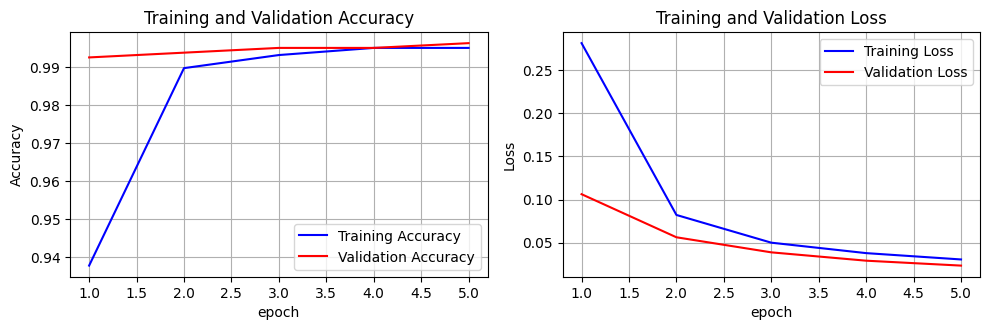

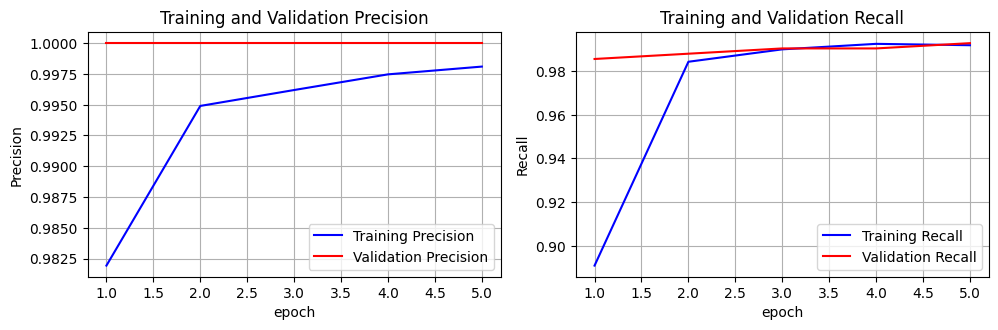

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
pre = history.history['precision']
val_pre = history.history['val_precision']
rec = history.history['recall']
val_rec = history.history['val_recall']

epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = 'red')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color = 'Blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color = 'red')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 3)
plt.plot(epochs_range, pre, label='Training Precision', color = 'blue')
plt.plot(epochs_range, val_pre, label='Validation Precision', color = 'red')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.title('Training and Validation Precision')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_range, rec, label='Training Recall', color = 'Blue')
plt.plot(epochs_range, val_rec, label='Validation Recall', color = 'red')
plt.legend()
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.title('Training and Validation Recall')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
def F1(pre, rec):
    pre = np.array(pre)
    rec = np.array(rec)
    return (2 * (pre*rec)/(pre+rec))

f1 = F1(pre, rec)
val_f1 = F1(val_pre, val_rec)

print(f"Training F1: {f1}")
print(f"Validation F1: {val_f1}")


Training F1: [0.9342149  0.98954043 0.99304237 0.9949431  0.99493993]
Validation F1: [0.99270073 0.99392468 0.99514562 0.99514562 0.99636364]


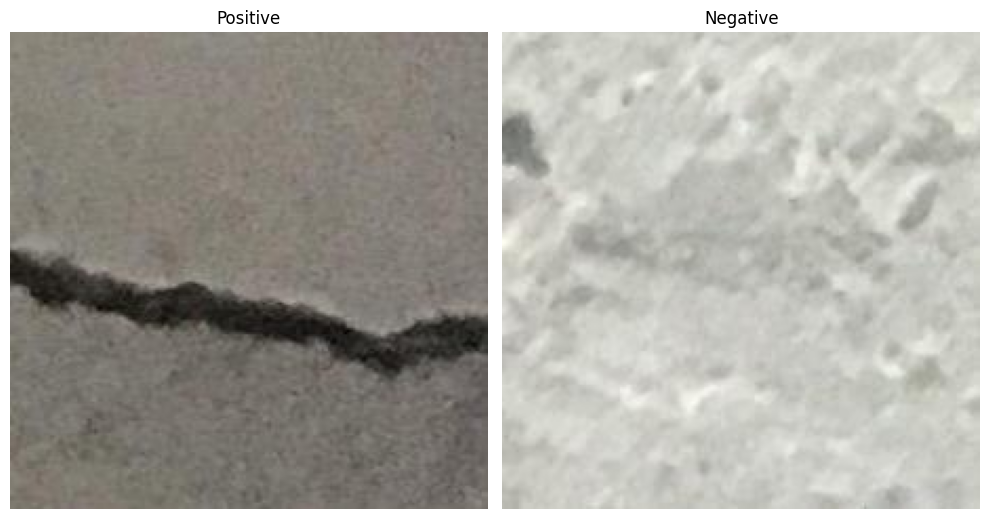

In [ ]:
# Test on Random Images for Visual
import numpy as np
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image # type: ignore

# Random Image with Crack
positive_image_path = f"/content/drive/MyDrive/Mendeley Data/Positive/{r.randint(0, 10000):05}.jpg"
# Random Image without Crack
negative_image_path = f"/content/drive/MyDrive/Mendeley Data/Negative/{r.randint(0, 10000):05}.jpg"

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(positive_image_path))
plt.title("Positive")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(negative_image_path))
plt.title("Negative")
plt.axis('off')
plt.tight_layout()
plt.show()

pos_crack = image.load_img(positive_image_path, target_size=(img_width, img_height))
pos_crack_array = image.img_to_array(pos_crack)
pos_crack_array = np.expand_dims(pos_crack_array, axis=0)

neg_crack = image.load_img(negative_image_path, target_size=(img_width, img_height))
neg_crack_array = image.img_to_array(neg_crack)
neg_crack_array = np.expand_dims(neg_crack_array, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


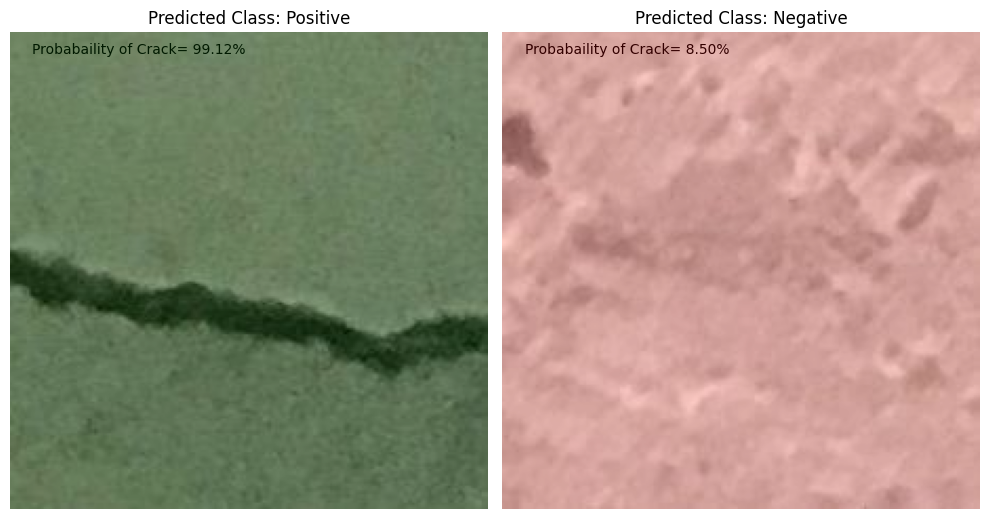

In [ ]:
# Plotting
import matplotlib.patches as patches

predictions = model.predict(pos_crack_array)
predicted_class = class_names[0] if predictions[0][0] < 0.5 else class_names[1]
hue = 'red' if predictions[0][0] < 0.5 else 'green'
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(positive_image_path))
ax = plt.gca()
overlay = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor= hue, alpha=0.2, zorder=10)
ax.add_patch(overlay)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.text(10, 10, f"Probabaility of Crack= {float(predictions[0][0])*100:.2f}%", fontsize = 10)


predictions = model.predict(neg_crack_array)
predicted_class = class_names[0] if predictions[0][0] < 0.5 else class_names[1]
hue = 'red' if predictions[0][0] < 0.5 else 'green'
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(negative_image_path))
ax = plt.gca()
overlay = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor= hue, alpha=0.2, zorder=10)
ax.add_patch(overlay)
plt.title(f"Predicted Class: {predicted_class}")
plt.text(10, 10, f"Probabaility of Crack= {float(predictions[0][0])*100:.2f}%", fontsize = 10)
plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/tmp/ipython-input-970360148.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i][j].legend(loc = (0, 0), frameon = False, fontsize = 10, title = f"{predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

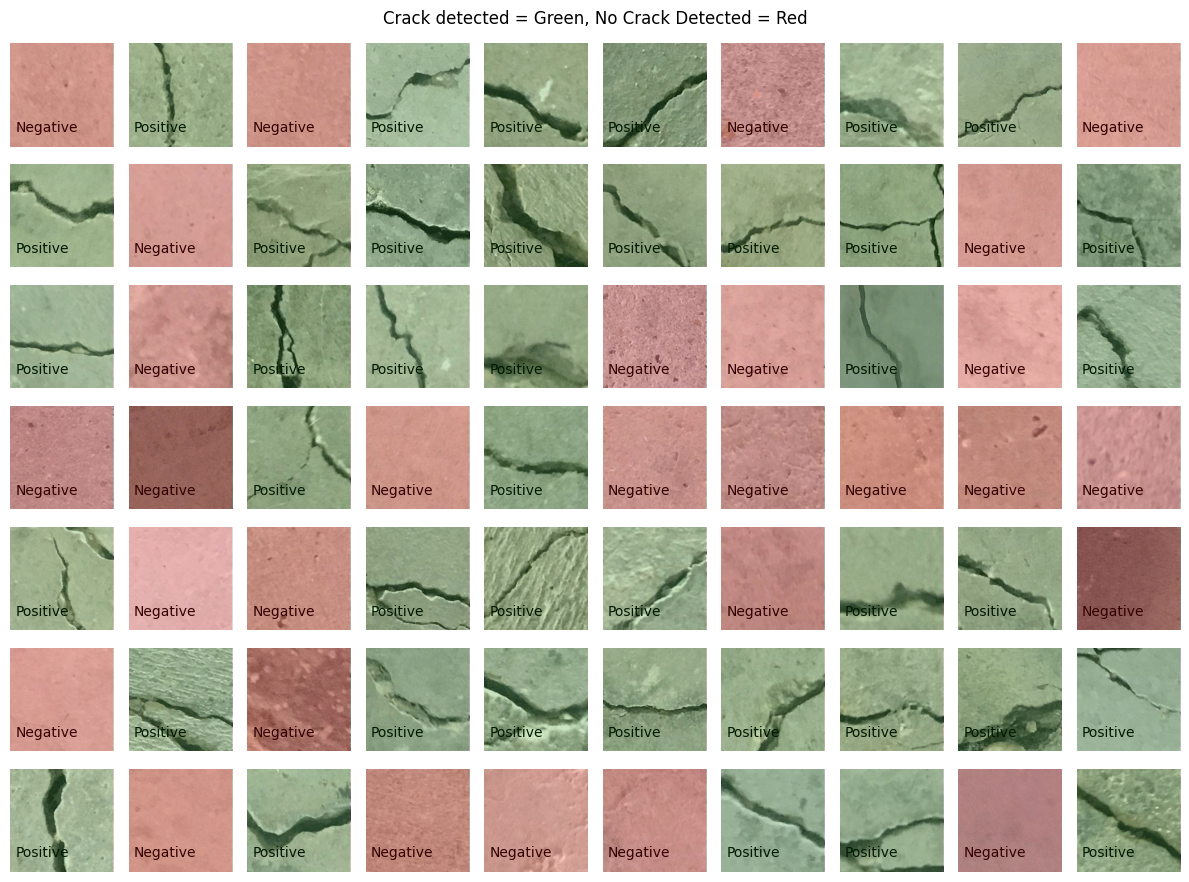

In [ ]:
# n x m grid of predictions
import numpy as np
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image # type: ignore
import matplotlib.patches as patches

def Detect(n, m):
    fig, axs = plt.subplots(n, m, figsize = (m + 2, n + 2))
    fig.suptitle("Crack detected = Green, No Crack Detected = Red")
    for i in range(n):
        for j in range(m):
            p = 0 if r.random() < .5 else 1
            image_path = f"/content/drive/MyDrive/Mendeley Data/{class_names[p]}/{r.randint(0, 10000):05}.jpg"

            pic = image.load_img(image_path, target_size=(img_width, img_height))
            pic_array = image.img_to_array(pic)
            pic_array = np.expand_dims(pic_array, axis=0)

            predictions = model.predict(pic_array)
            predicted_class = class_names[0] if predictions[0][0] < 0.5 else class_names[1]
            hue = 'red' if predictions[0][0] < 0.5 else 'green'

            axs[i][j].imshow(mpimg.imread(image_path))
            axs[i][j].add_patch(patches.Rectangle((0, 0), 1, 1, transform=axs[i][j].transAxes, facecolor= hue, alpha=0.2, zorder=10))
            axs[i][j].axis('off')
            axs[i][j].legend(loc = (0, 0), frameon = False, fontsize = 10, title = f"{predicted_class}")
    plt.tight_layout()
    plt.show()
Detect(7, 10)

In [ ]:
# Save to Google Drive
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/CNN_for_UAV.keras")